In [ ]:
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=e2b8f05188451fd9b33c17230f3fc5945c3d02e5b060068d10892928449e9764
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


### Chargement des données à partir des fichiers CSV

Dans cette section, nous chargeons les données à partir des fichiers CSV préalablement enregistrés sur Google Drive. Les données sont stockées dans les DataFrames `app_train`, `app_test`, `app_train_features` et `app_test_features`, qui seront utilisées pour l'analyse exploratoire et la classification.

In [ ]:
from google.colab import drive
import pandas as pd

# Montez Google Drive dans Colab
drive.mount('/content/drive')

# Chemin vers le dossier sur Google Drive contenant les fichiers CSV
folder_path = '/content/drive/MyDrive/oc_projet_4/Data/'

# Charger les données à partir des fichiers CSV
app_train = pd.read_csv(folder_path + 'app_train_traitees.csv')
app_test = pd.read_csv(folder_path + 'app_test_traitees.csv')
app_train_features = pd.read_csv(folder_path + 'app_train_features.csv')
app_test_features = pd.read_csv(folder_path + 'app_test_features.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Analyse SHAP avec un modèle de Régression logistique simple

Dans ce modèle, nous avons utilisé un modèle de régression logistique pour effectuer des prédictions sur un ensemble de données. L'objectif principal était d'évaluer les performances du modèle de base en termes de différentes métriques telles que l'accuracy, la précision, le recall ou le F1 Score.

L'objectif supplémentaire est maintenant de calculer l'importance des features globale avec un modèle de base. Pour ce faire, nous utiliserons des techniques telles que la permutation des caractéristiques et l'importance basée sur les coefficients du modèle de régression logistique.

Ces analyses nous permettront de comprendre quelles caractéristiques ont le plus d'influence sur les prédictions du modèle, ce qui est essentiel pour interpréter les résultats et fournir des informations explicatives aux parties prenantes.


In [ ]:
import numpy as np  # Importation de la bibliothèque NumPy pour les calculs numériques
from sklearn.model_selection import train_test_split  # Importation de la fonction train_test_split de scikit-learn pour diviser les données en ensembles d'entraînement et de test
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

X = app_train.drop(columns=['TARGET'])  # Extraction des caractéristiques (X) en supprimant la colonne 'TARGET' du DataFrame app_train
y = app_train['TARGET']  # Extraction de la cible (y) à partir de la colonne 'TARGET' du DataFrame app_train
print(type(X))

# Imputation des valeurs manquantes en remplaçant les NaN par la médiane de chaque colonne
imputer = SimpleImputer(strategy='median')  # Création d'un objet Imputer qui remplace les valeurs manquantes par la médiane
imputer.fit(X)  # Ajustement de l'impute sur les données d'entraînement

X = imputer.transform(X)  # Transformation des données en remplaçant les valeurs manquantes par la médiane

# Mise à l'échelle de chaque caractéristique entre 0 et 1 pour standardiser les données
scaler = MinMaxScaler(feature_range=(0, 1))  # Création d'un objet Scaler pour mettre à l'échelle les caractéristiques entre 0 et 1
scaler.fit(X)  # Ajustement du scaler sur les données d'entraînement

X = scaler.transform(X)  # Transformation des données en mettant à l'échelle chaque variable entre 0 et 1
print(type(X))
# Division des données en ensembles d'entraînement et de test (67% pour l'entraînement, 33% pour le test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.linear_model import LogisticRegression

# Créer le modèle avec le paramètre de régularisation spécifié
log_reg = LogisticRegression(C=0.0001)

# Entraîner sur les données d'entraînement
log_reg.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Faire des prédictions sur l'ensemble de données de test
predictions = log_reg.predict(X_test)

# Calculer les différentes métriques
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Afficher les métriques
print("Métriques pour le modèle de régression logistique :")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1}")


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Métriques pour le modèle de régression logistique :
Accuracy : 0.9200130076173395
Precision : 0.0
Recall : 0.0
F1 Score : 0.0


Dans cette section, nous allons calculer l'importance des caractéristiques globales à l'aide de la méthode SHAP (SHapley Additive exPlanations). SHAP est une technique d'interprétation de modèle qui attribue une valeur à chaque caractéristique pour chaque prédiction. Cela nous permet de comprendre l'impact de chaque caractéristique sur les prédictions du modèle.

Nous utiliserons notre modèle de régression logistique pour cet exemple, et nous examinerons l'importance des caractéristiques pour ce modèle spécifique. Tout d'abord, nous préparerons nos données en extrayant les caractéristiques et la cible, puis nous créerons un DataFrame pour faciliter la visualisation. Ensuite, nous utiliserons la bibliothèque SHAP pour calculer les valeurs SHAP et les visualiser sous forme de graphique de résumé.

Cela nous permettra de voir quelles caractéristiques ont le plus d'impact sur les prédictions de notre modèle de régression logistique.


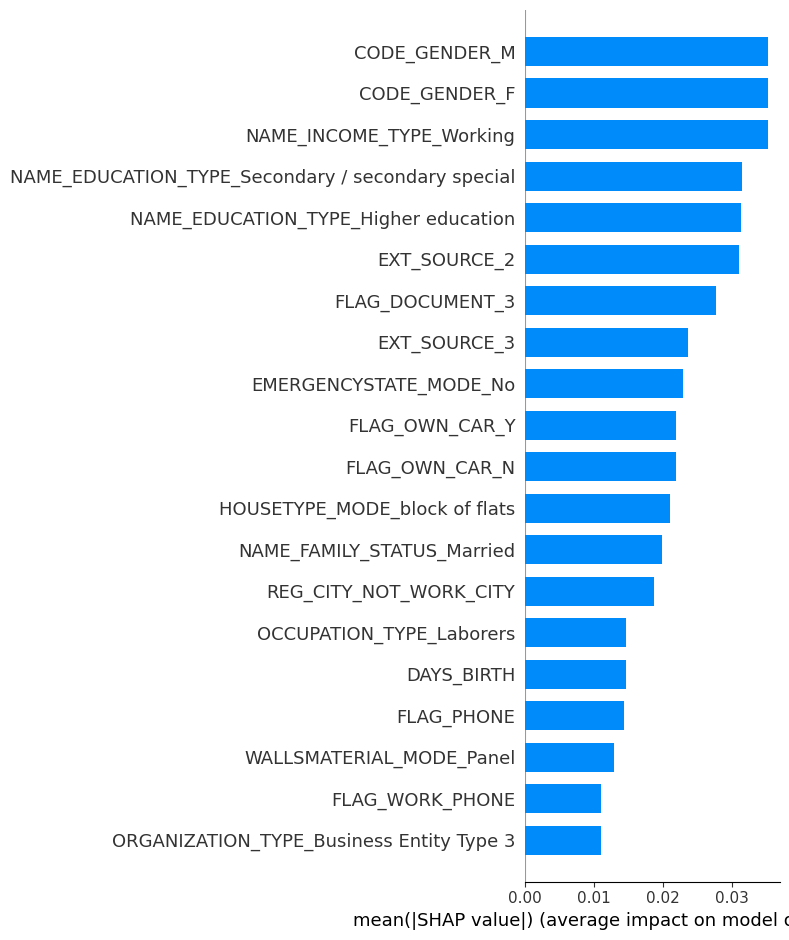

In [ ]:
import pandas as pd
import shap

X = app_train.drop(columns=['TARGET'])  # Extraction des caractéristiques (X) en supprimant la colonne 'TARGET' du DataFrame app_train
y = app_train['TARGET']  # Extraction de la cible (y) à partir de la colonne 'TARGET' du DataFrame app_train

# Récupérer les noms des colonnes de X
column_names = X.columns

# Créer un DataFrame à partir de X_train en utilisant les noms des colonnes de X
X_train_df = pd.DataFrame(X_train, columns=column_names)
X_test_df = pd.DataFrame(X_train, columns=column_names)

# Créer un objet explainer SHAP avec le modèle de régression logistique et spécifier les noms de colonnes
explainer = shap.Explainer(log_reg, X_train_df, feature_names=X_train_df.columns)

# Calculer les valeurs SHAP
shap_values = explainer.shap_values(X_train_df)

# Afficher un résumé des valeurs SHAP sous forme de barres avec les noms des caractéristiques
shap.summary_plot(shap_values, X_train_df, plot_type='bar')


Dans cette partie, nous calculons l'importance moyenne des caractéristiques en utilisant les valeurs SHAP que nous avons précédemment calculées. Les valeurs SHAP représentent l'impact de chaque caractéristique sur les prédictions du modèle.

1. Nous calculons d'abord la moyenne des valeurs SHAP pour chaque caractéristique en prenant la valeur absolue et en prenant la moyenne sur toutes les observations.
2. Ensuite, nous créons un DataFrame pour stocker l'importance des caractéristiques, en associant chaque caractéristique à sa valeur moyenne de SHAP.
3. Nous trions ensuite ce DataFrame pour obtenir les 10 premières caractéristiques avec les valeurs SHAP moyennes les plus élevées.
4. Enfin, nous affichons ces 10 premières caractéristiques avec leurs valeurs SHAP moyennes.

Cela nous permettra de déterminer quelles caractéristiques ont le plus d'importance dans notre modèle de régression logistique, ce qui peut être utile pour comprendre les facteurs les plus influents dans nos prédictions.


In [ ]:
import numpy as np

# Calculer l'importance moyenne des caractéristiques en utilisant les valeurs SHAP
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Créer un DataFrame pour stocker l'importance des caractéristiques
feature_importance_df = pd.DataFrame({'Feature': X_train_df.columns, 'Mean SHAP Value': mean_shap_values})

# Trier les caractéristiques par leur importance moyenne
top_10_features = feature_importance_df.sort_values(by='Mean SHAP Value', ascending=False).head(10)

# Afficher les 10 premières caractéristiques avec leurs valeurs SHAP moyennes
print(top_10_features)


                                               Feature  Mean SHAP Value
109                                      CODE_GENDER_M         0.035192
108                                      CODE_GENDER_F         0.035185
127                           NAME_INCOME_TYPE_Working         0.035153
132  NAME_EDUCATION_TYPE_Secondary / secondary special         0.031466
129               NAME_EDUCATION_TYPE_Higher education         0.031270
29                                        EXT_SOURCE_2         0.030973
80                                     FLAG_DOCUMENT_3         0.027628
30                                        EXT_SOURCE_3         0.023592
241                             EMERGENCYSTATE_MODE_No         0.022895
111                                     FLAG_OWN_CAR_Y         0.021870


Les résultats montrent les 10 caractéristiques les plus importantes selon l'analyse SHAP. Voici une interprétation de ces résultats :

1. **CODE_GENDER_M et CODE_GENDER_F :** Il semble que le genre (masculin et féminin) ait une forte influence sur les prédictions du modèle.
2. **NAME_INCOME_TYPE_Working :** Le fait d'avoir un revenu provenant d'un travail est également très important dans les prédictions du modèle.
3. **NAME_EDUCATION_TYPE_Secondary / secondary special et NAME_EDUCATION_TYPE_Higher education :** Le niveau d'éducation, en particulier le fait d'avoir terminé le secondaire ou des études supérieures, est également un facteur déterminant.
4. **EXT_SOURCE_2 et EXT_SOURCE_3 :** Ces caractéristiques sont des indices de crédit normalisés. Il est logique qu'ils aient une influence significative sur les prédictions du modèle.
5. **FLAG_DOCUMENT_3 :** La possession du document 3 semble également avoir une certaine influence.
6. **EMERGENCYSTATE_MODE_No :** Le fait de ne pas être en état d'urgence semble être un facteur important.
7. **FLAG_OWN_CAR_Y :** Le fait de posséder une voiture semble également avoir une certaine importance dans les prédictions.

Ces résultats nous aident à comprendre quelles caractéristiques sont les plus importantes pour notre modèle de régression logistique et peuvent guider nos efforts pour interpréter et expliquer les prédictions du modèle aux parties prenantes.


## Analyse SHAP avec un Modèle de Regression Logistique amélioré

Dans cette section, nous allons poursuivre notre analyse en utilisant un modèle de régression logistique plus avancé, qui a été entraîné et évalué précédemment. Nous allons maintenant explorer l'importance des caractéristiques à l'aide de la méthode SHAP (SHapley Additive exPlanations).

Nous utiliserons les valeurs SHAP pour comprendre l'impact de chaque caractéristique sur les prédictions du modèle. Cela nous permettra d'identifier les caractéristiques les plus importantes pour la prédiction de la variable cible et de mieux comprendre les décisions prises par le modèle.

Nous examinerons les valeurs SHAP moyennes pour chaque caractéristique, en mettant l'accent sur les caractéristiques les plus influentes selon cette mesure. Cela nous fournira des informations précieuses sur la manière dont le modèle utilise les caractéristiques pour effectuer des prédictions.

Nous commençons par charger les données, entraîner le modèle de régression logistique et évaluer ses performances. Ensuite, nous procéderons à l'analyse SHAP en utilisant le modèle entraîné.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Métriques pour le modèle de régression logistique avec GridSearchCV:
Custom Score : 48916
Accuracy : 0.6988276994618149
Precision : 0.16297546926209155
Recall : 0.6631642756112346
F1 Score : 0.2616494598796189
AUC Score : 0.7469670248945082
Meilleur seuil : 0.08401669876463232


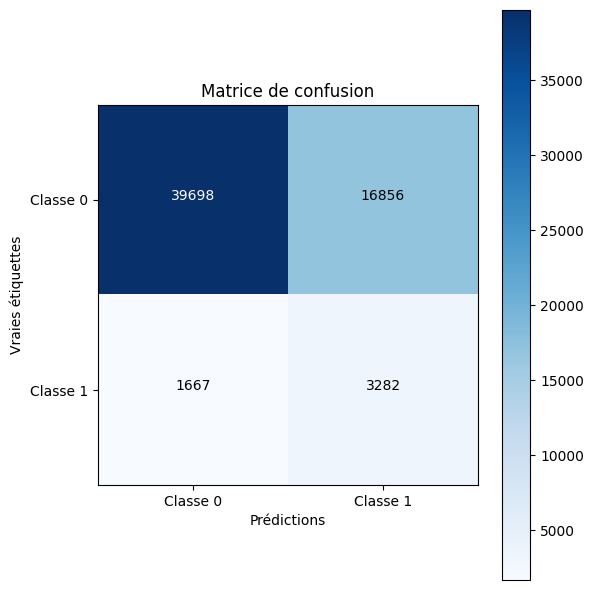

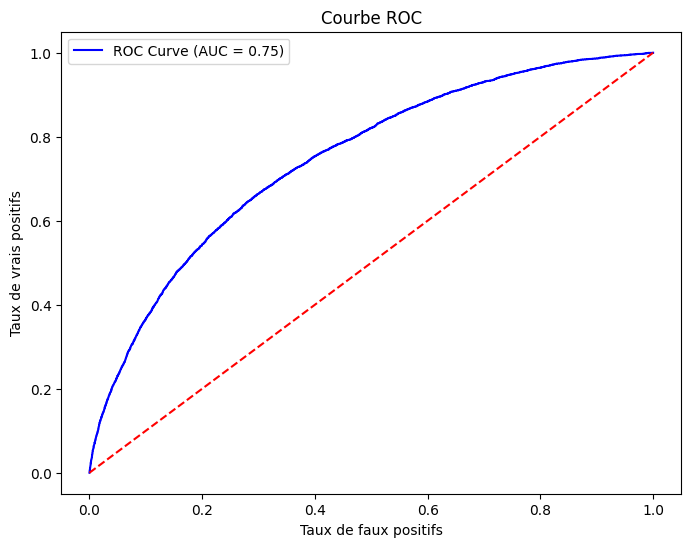

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Définir le score métier personnalisé
def custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp

# Créer un scorer adapté au GridSearchCV pour le score métier personnalisé
custom_scorer = make_scorer(custom_score, greater_is_better=False)

# Fonction pour trouver le meilleur seuil
def find_best_threshold(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]
    return best_threshold

# Chargement des données
X = app_train.drop(columns=['TARGET'])  # Extraction des caractéristiques (X) en supprimant la colonne 'TARGET' du DataFrame app_train
y = app_train['TARGET']  # Extraction de la cible (y) à partir de la colonne 'TARGET' du DataFrame app_train

# Imputation des valeurs manquantes en remplaçant les NaN par la médiane
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Mise à l'échelle des caractéristiques
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Séparation en ensemble d'entraînement et ensemble de validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le modèle de régression logistique
logistic_regression_model = LogisticRegression()

# Définir une grille de paramètres à rechercher
param_grid = {}

# Créer une instance de GridSearchCV avec le score métier personnalisé
grid_search = GridSearchCV(logistic_regression_model, param_grid=param_grid, cv=5, scoring=custom_scorer, refit=True)

# Exécuter la recherche sur grille
grid_search.fit(X_train, y_train)

# Obtenir le meilleur modèle
best_model = grid_search.best_estimator_

# Faire des prédictions sur l'ensemble de données de validation
predictions = best_model.predict(X_validation)

# Calculer le score métier personnalisé
custom_score_val = custom_score(y_validation, predictions)

# Obtenir les probabilités prédites pour la classe positive
probs = best_model.predict_proba(X_validation)[:, 1]

# Trouver le meilleur seuil
best_threshold = find_best_threshold(y_validation, probs)

# Faire des prédictions sur l'ensemble de données de validation avec le seuil optimal
predictions_with_threshold = (probs >= best_threshold).astype(int)

# Calculer les différentes métriques
accuracy = accuracy_score(y_validation, predictions_with_threshold)
precision = precision_score(y_validation, predictions_with_threshold)
recall = recall_score(y_validation, predictions_with_threshold)
f1 = f1_score(y_validation, predictions_with_threshold)

# Calculer le score AUC
fpr, tpr, thresholds = roc_curve(y_validation, probs)
auc_score = auc(fpr, tpr)

# Afficher les métriques
print("Métriques pour le modèle de régression logistique avec GridSearchCV:")
print(f"Custom Score : {custom_score_val}")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 Score : {f1}")
print(f"AUC Score : {auc_score}")
print(f"Meilleur seuil : {best_threshold}")

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_validation, predictions_with_threshold)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Classe 0', 'Classe 1'])
plt.yticks(tick_marks, ['Classe 0', 'Classe 1'])
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='white' if conf_matrix[i][j] > conf_matrix.max() / 2 else 'black')
plt.tight_layout()
plt.show()

# Afficher la courbe ROC avec le seuil optimal
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend()
plt.show()

# Définir les résultats du modèle
resultats = {
    "Métrique": ["Score Metier","Accuracy", "Precision", "Recall", "F1 Score", "AUC Score", "Meilleur Seuil"],
    "Régression Logistique (Avant Suréchantillonnage)": [custom_score_val, accuracy, precision, recall, f1, auc_score, best_threshold]
}


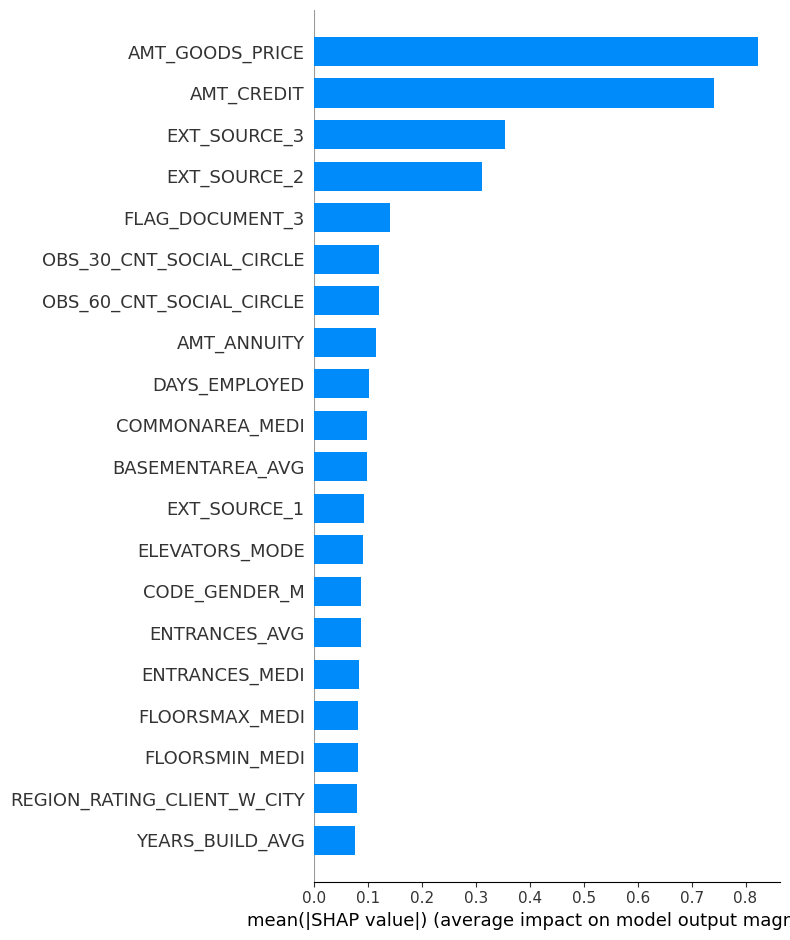

In [ ]:
import pandas as pd

X = app_train.drop(columns=['TARGET'])  # Extraction des caractéristiques (X) en supprimant la colonne 'TARGET' du DataFrame app_train
y = app_train['TARGET']  # Extraction de la cible (y) à partir de la colonne 'TARGET' du DataFrame app_train

# Récupérer les noms des colonnes de X
column_names = X.columns

# Créer un DataFrame à partir de X_train en utilisant les noms des colonnes de X
X_train_df = pd.DataFrame(X_train, columns=column_names)
X_test_df = pd.DataFrame(X_train, columns=column_names)

# Créer un objet explainer SHAP avec le modèle de régression logistique et spécifier les noms de colonnes
explainer = shap.Explainer(best_model, X_train_df, feature_names=X_train_df.columns)

# Calculer les valeurs SHAP
shap_values = explainer.shap_values(X_train_df)

# Afficher un résumé des valeurs SHAP sous forme de barres avec les noms des caractéristiques
shap.summary_plot(shap_values, X_train_df, plot_type='bar')

In [ ]:
import numpy as np

# Calculer l'importance moyenne des caractéristiques en utilisant les valeurs SHAP
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Créer un DataFrame pour stocker l'importance des caractéristiques
feature_importance_df = pd.DataFrame({'Feature': X_train_df.columns, 'Mean SHAP Value': mean_shap_values})

# Trier les caractéristiques par leur importance moyenne
top_10_features = feature_importance_df.sort_values(by='Mean SHAP Value', ascending=False).head(10)

# Afficher les 10 premières caractéristiques avec leurs valeurs SHAP moyennes
print(top_10_features)

                     Feature  Mean SHAP Value
5            AMT_GOODS_PRICE         0.822846
3                 AMT_CREDIT         0.742280
30              EXT_SOURCE_3         0.352687
29              EXT_SOURCE_2         0.310493
80           FLAG_DOCUMENT_3         0.140286
74  OBS_30_CNT_SOCIAL_CIRCLE         0.119807
76  OBS_60_CNT_SOCIAL_CIRCLE         0.119214
4                AMT_ANNUITY         0.113418
8              DAYS_EMPLOYED         0.100743
63           COMMONAREA_MEDI         0.098048


Ces valeurs représentent l'importance moyenne des caractéristiques pour expliquer les prédictions du modèle. Voici une interprétation de ces valeurs :

1. **AMT_GOODS_PRICE** : Cette caractéristique a la plus grande importance moyenne selon les valeurs SHAP. Cela indique que le prix des biens a un impact significatif sur les prédictions du modèle. Une augmentation du prix des biens entraîne probablement une augmentation de la probabilité de la cible.

2. **AMT_CREDIT** : La valeur SHAP pour cette caractéristique est également élevée, ce qui suggère que le montant du crédit accordé est un facteur important dans les prédictions du modèle. Une augmentation du montant du crédit pourrait influencer positivement la probabilité de la cible.

3. **EXT_SOURCE_3** et **EXT_SOURCE_2** : Ces caractéristiques représentent probablement des scores de crédit externes. Des valeurs SHAP élevées pour ces caractéristiques indiquent qu'elles sont également importantes pour le modèle. Des scores de crédit plus élevés (EXT_SOURCE_3 et EXT_SOURCE_2) pourraient être associés à une probabilité plus faible de la cible.

4. **FLAG_DOCUMENT_3** : Cette caractéristique binaire semble également avoir une influence significative sur les prédictions du modèle. Son effet sur la probabilité de la cible est moins clair sans connaître la signification exacte de cette variable.

5. **OBS_30_CNT_SOCIAL_CIRCLE** et **OBS_60_CNT_SOCIAL_CIRCLE** : Ces caractéristiques représentent probablement le nombre d'observations dans le cercle social de l'emprunteur. Leur importance suggère qu'elles peuvent être liées à la probabilité de la cible, mais leur interprétation exacte nécessiterait une analyse plus approfondie.

6. **AMT_ANNUITY**, **DAYS_EMPLOYED** et **COMMONAREA_MEDI** : Ces caractéristiques ont également des valeurs SHAP élevées, indiquant leur importance dans les prédictions du modèle. Cependant, leur interprétation spécifique dépendrait de leur signification dans le contexte des données.

## Analyse LIME avec le Modèle de Régression Logistique amélioré

Une autre approche pour expliquer les prédictions d'un modèle est d'utiliser LIME (Local Interpretable Model-agnostic Explanations). LIME est une méthode qui vise à expliquer les prédictions d'un modèle de manière locale et interprétable en approximant localement le modèle principal par un modèle linéaire simple.


In [ ]:
import lime
import lime.lime_tabular
from lime import lime_text
from lime.lime_text import LimeTextExplainer

# Créer un explainer LIME pour les prédictions de régression logistique
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['Non-Default', 'Default'], discretize_continuous=True)

# Sélectionner une instance de données de validation pour expliquer
instance_idx = 0  # Indice de l'instance à expliquer (modifier selon les besoins)

# Préparer les données de l'instance sélectionnée
instance = X_validation[instance_idx]
exp_class = best_model.predict(instance.reshape(1, -1))[0]

# Expliquer la prédiction du modèle pour l'instance sélectionnée
explanation = explainer.explain_instance(instance, best_model.predict_proba, num_features=len(X.columns))

# Afficher l'explication
explanation.show_in_notebook()


*Interprétation des Importances des Caractéristiques*

Les valeurs indiquées représentent l'importance des caractéristiques pour prédire les classes "Default" et "Non-Default" dans votre ensemble de données.

1. **Default et Non-Default** : Ces deux classes représentent les deux catégories de votre variable cible. Une caractéristique importante pour l'une des classes indique son rôle dans la prédiction de cette classe spécifique. Par exemple, une valeur élevée pour "Default" indique que cette caractéristique est importante pour prédire les cas où un défaut de paiement est plus probable.

2. **FLAG_DOCUMENT** : Les caractéristiques liées aux documents semblent jouer un rôle significatif dans la prédiction de la classe. Cela pourrait indiquer que la présence ou l'absence de certains documents est un facteur important dans la prédiction du défaut de paiement.

3. **ORGANIZATION_TY.** : Les caractéristiques liées au type d'organisation semblent également être importantes pour la prédiction. Cela suggère que le type d'organisation du demandeur peut influencer la probabilité de défaut de paiement.

4. **NAME_INCOME_TY** : Les caractéristiques liées au type de revenu semblent également jouer un rôle important dans la prédiction. Cela peut indiquer que le type de revenu du demandeur est un facteur crucial dans la décision de prédire un défaut de paiement.

5. **NAME_EDUCATION** : Les caractéristiques liées au niveau d'éducation semblent également être pertinentes. Cela pourrait signifier que le niveau d'éducation du demandeur influence sa capacité à rembourser un prêt et donc sa probabilité de défaut de paiement.

En résumé, ces résultats indiquent quelles caractéristiques sont importantes pour prédire les classes "Default" et "Non-Default".
